In [112]:
import numpy as np
import pandas as pd
import random as rand
import seaborn as sns
import time
from matplotlib import pyplot as plt

%pylab inline
pylab.rcParams['figure.figsize'] = (16, 8)
pylab.rcParams['figure.figsize'] = (20, 12)
plt.style.use('fivethirtyeight')

Populating the interactive namespace from numpy and matplotlib


C:\Users\jdetu\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['test', 'rand']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Define functions to prep data.

In [113]:
def train_test_valid(df, train_ratio = 0.6, valid_ratio = 0.2 ):
    
    train, test, validation = np.split(df.sample(frac = 1, 
                                                 random_state = random.randint(1,1e3)), 
                                       [int(train_ratio * len(df)), 
                                        int((train_ratio + valid_ratio) * len(df))])
    
    return train, test, validation

def normalize(df, mean_method = True ):
    if mean_method:
        # mean normalization
        normalized_df = (df - df.mean()) / df.std()
        a, b = df.std(), df.mean()
    else:
        # min max normalization
        normalized_df = (df - df.min()) / (df.max() - df.min())
        a, b = df.min(), df.max()
    return normalized_df, a, b

def unnormalize(df, a, b, mean_method = True):
    if mean_method:
        # mean normalization
        unnormalized_df = df * a + b
    else:
        # min max normalization
        unnormalized_df = (df * (b - a)) + a
    return unnormalized_df

# Nearest Neighbor

In [114]:
class KNearest_Neighbor:
    
    def __init__(self,x_train, y_train,x_test,y_test, k = 10):
        
        self.k = k
        
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        
    def MSE(self, y_pred, y_train):
        return np.sum((y_pred - y_train) ** 2) / (2 * y_train.shape[0])   
    
    def fit(self, x_train, y_train):
        
        # compute distance matrix
        a = np.einsum('ij, ij ->i', self.x_test, self.x_test)[:, None]
        b = np.einsum('ij, ij ->i', x_train, x_train)
        c = 2 * self.x_test.dot(x_train.T)
        
        self.distances_sq = a + b - c
    
    def predict(self, x_test):
    
        # calculate the mean of the k neighbours - the prediction
        y_pred = np.mean(self.y_train[np.argsort(self.distances_sq)[:,:self.k]], axis=1)
        
        MSE = self.MSE(y_pred,self.y_test)
        #return the prediction
        return y_pred, MSE

# Test Model on Toy Problem

Text(0.5, 1.0, 'Toy Data')

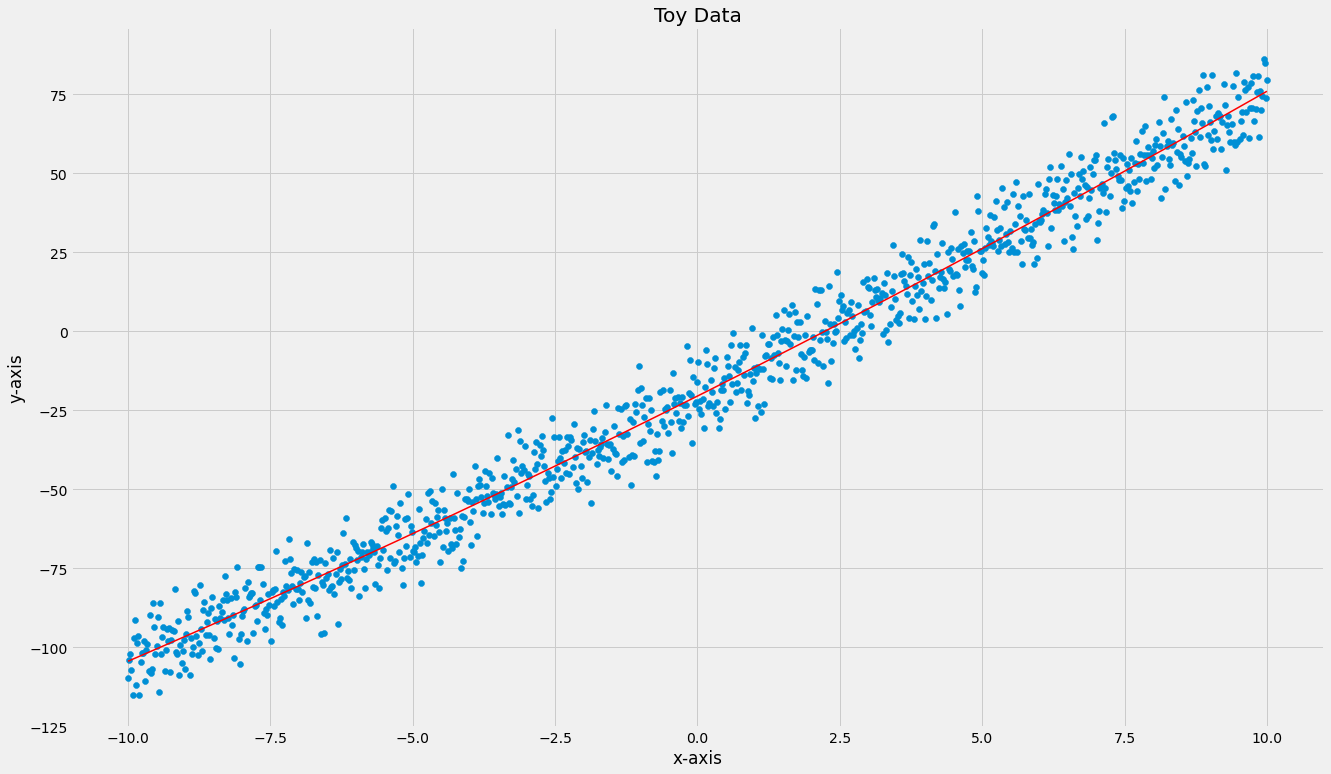

In [115]:
# create synthetic data from polynomial with random coeffs and noise

import random as rand
def f_toy(normal = False, linear = False):
    
    if normal:
        x = []
        for i in range(1000): 
            x.append(random.normal(10, 5))
    else:
        x = np.linspace(-10,10, 1000)
    
    y = []
    y_actual = []
    a = rand.uniform(-1,1)
    b = rand.uniform(-10,10)
    c = rand.uniform(-100,100)
    exp =  2 #rand.randint(0,3)
    
    for i in range(len(x)):
        
        noise = rand.uniform(rand.randint(-20,0),rand.randint(0,20))
        
        if linear:
            y.append(a*x[i] + b + noise)
            y_actual.append(a*x[i] + b)
        else:
            y.append(a*x[i]**exp + b*x[i] + c + noise)
            y_actual.append(a*x[i]**exp + b*x[i] + c)
            
    return x, y, y_actual
    
x, y, y_actual = f_toy(normal = False, linear = False)
plt.scatter(x,y)
plt.plot(x,y_actual, c = 'r', linewidth = 1.5)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Toy Data')

In [116]:
# create datafame from toy data
df_toy = pd.DataFrame(list(x), columns=['x'])
df_toy['y'] = y

# randomly split with 60 / 20 / 20 ratio
train, test, validation = train_test_valid(df_toy)

# normalize data
train, test, valid = normalize(train), normalize(test), normalize(validation)

# seperate input data from target variable
x_train, y_train = train[0].iloc[:,:-1], train[0].iloc[:,-1]
x_test, y_test = test[0].iloc[:,:-1], test[0].iloc[:,-1]
x_valid, y_valid = valid[0].iloc[:,:-1], valid[0].iloc[:,-1]

# convert data to array for model fitting
x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)
x_valid, y_valid = np.array(x_valid), np.array(y_valid)

In [117]:
# create KNN class
KNN = KNearest_Neighbor(x_train, y_train, x_test, y_test, 10)

# fit model to training data
KNN.fit(x_train,y_train)

# predict from test data
y_pred, MSE= KNN.predict(x_test)
print("Mean Squared Error: {}".format(MSE))

Mean Squared Error: 0.011422204159409852


In [118]:
# unnormalize data
x_test, y_test = unnormalize(x_test, test[1]['x'], test[2]['x']), unnormalize(y_test, test[1]['y'],  test[2]['y'])
y_pred = unnormalize(y_pred, test[1]['y'],  test[2]['y'])

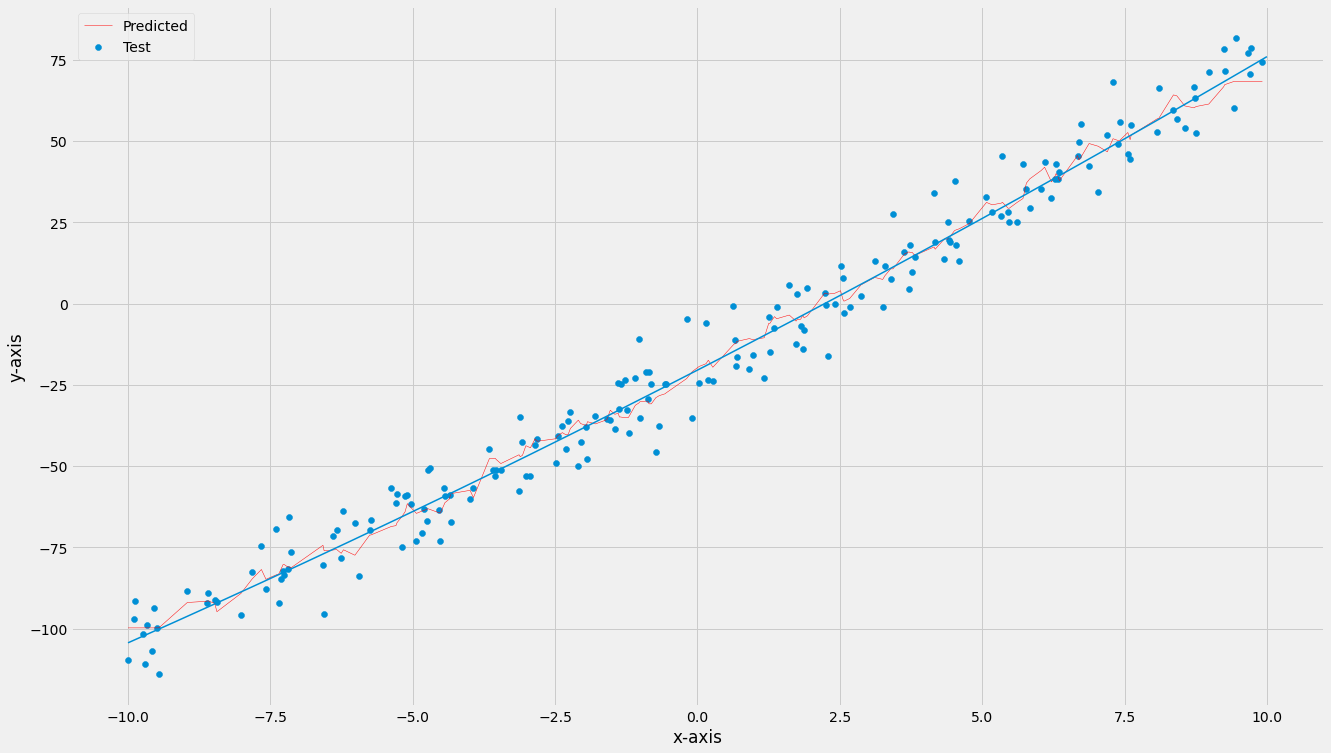

In [119]:
# plot toy data and model prediction

df_pred = pd.DataFrame(x_test, columns = ['x_test'])
df_pred['y_test'] = y_test
df_pred['y_pred'] = y_pred

df_pred.sort_values(by = ['x_test'], inplace = True)

plt.scatter(x_test,y_test, 
            label = 'Test')
plt.plot(df_pred['x_test'],df_pred['y_pred'], 
         c = 'red', 
         linewidth = 0.5,
            alpha = 0.95,
         label = 'Predicted')
plt.plot(x,y_actual, linewidth = 1.5)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.legend()

In [12]:
def normalize_yield(df):
    # normalize with average of each year
    adjusted_yield = []
    for i in range(1983,2014):
        adjusted_yield.extend((df[df['year'] == i]['yield'] /df[df['year'] == i]['yield'].mean()))

    df['adjusted_yield'] = adjusted_yield
    df = df.drop(['yield'], axis = 1)
    return df

def unnormalize_yield(df_pred,y_test, df):
    y_pred_new = []
    y_test_new = []
    for i in range(1983,2014):
        y_pred_new.extend(df_pred[df_pred.index == i]['y_pred'] * df[df['year'] == i]['yield'].mean())
        y_test_new.extend(y_test[i])
    return y_pred_new, y_test_new

# Import and process data

In [102]:
df_orig = pd.read_csv('maize_major_yield/maize_major_yield.csv')

#df = normalize_yield(df_orig)
df = df_orig.drop(['year'], axis = 1)
#df.set_index('year', inplace = True)
#df = df.drop(['yield'], axis = 1)

# randomly split with 60 / 20 / 20 ratio
train, test, validation = train_test_valid(df)

# normalize data
train, test, valid = normalize(train), normalize(test), normalize(validation)

# seperate input data from target variable
x_train, y_train = train[0].iloc[:,:-1], train[0].iloc[:,-1]
x_test, y_test = test[0].iloc[:,:-1], test[0].iloc[:,-1]
x_valid, y_valid = valid[0].iloc[:,:-1], valid[0].iloc[:,-1]

#
y_year = y_test.index

#
x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)
x_valid, y_valid = np.array(x_valid), np.array(y_valid)

# Run Model to Predict Crop Yield

In [103]:
# instantiate KNN
KNN = KNearest_Neighbor(x_train, y_train, x_test, y_test, 
                                                   k = 1)
# fit model to training data
KNN.fit(x_train,y_train)

# predict test data using model
y_pred, MSE= KNN.predict(x_test)
print("Mean Squared Error: {}".format(MSE))

Mean Squared Error: 0.23602431826867049


In [104]:
# unnormalize
y_test = unnormalize(test[0].iloc[:,-1], test[1][-1], test[2][-1])
y_pred = unnormalize(y_pred, test[1][-1],  test[2][-1])

df_pred = pd.DataFrame(y_pred, index = y_year, columns = ['y_pred'])

#y_pred, y_test = unnormalize_yield(df_pred,y_test, df_orig)

In [105]:
KNN.MSE(np.array(y_pred), np.array(y_test))

3.408965852286389

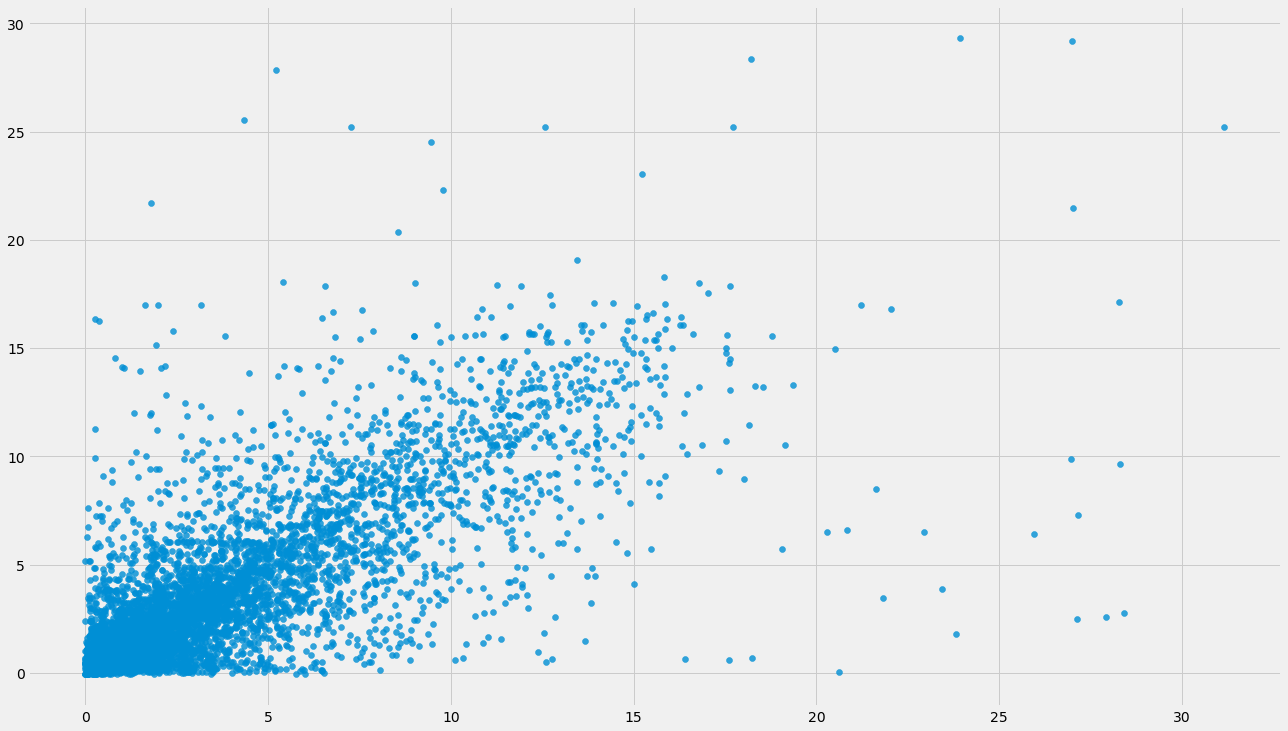

In [106]:
df_pred = pd.DataFrame(list(y_test), columns = ['y_test'])
df_pred['y_pred'] = list(y_pred)

plt.scatter(df_pred['y_test'], df_pred['y_pred'], alpha = 0.8)

In [107]:
df_pred.corr()

,y_test,y_pred
y_test,1.000000,0.762351
y_pred,0.762351,1.000000


In [23]:
# fresh reload of data for hyperparameter optimization

df_orig = pd.read_csv('maize_major_yield/maize_major_yield.csv')

#df = normalize_yield(df_orig)
#df = df.drop(['year'], axis = 1)
df = df_orig.drop(['year'], axis = 1)
#df.set_index('year', inplace = True)
#df = df.drop(['yield'], axis = 1)

# randomly split with 60 / 20 / 20 ratio
train, test, validation = train_test_valid(df)

# normalize data
train, test, valid = normalize(train), normalize(test), normalize(validation)

# seperate input data from target variable
x_train, y_train = train[0].iloc[:,:-1], train[0].iloc[:,-1]
x_test, y_test = test[0].iloc[:,:-1], test[0].iloc[:,-1]
x_valid, y_valid = valid[0].iloc[:,:-1], valid[0].iloc[:,-1]

#
y_year = y_test.index

#
x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)
x_valid, y_valid = np.array(x_valid), np.array(y_valid)

# Hyperparameter optimization with test data

In [43]:
k_space = list(range(1,30,1))

previous_MSE = np.inf

results = []
best_results = {}

iteration = 0
for ki in k_space:
    
        iteration += 1

        # start timer
        start = time.time()

        KNN = KNearest_Neighbor(x_train, y_train, x_test, y_test, 
                                                   k = ki)
        # fit model to training data
        KNN.fit(x_train,y_train)

        # predict test data using model
        y_pred, MSE= KNN.predict(x_test)

        # end timer
        end = time.time()
        time_diff =  end - start


        params =[ki]

        iter_results = {'params':params,
                        'MSE':MSE,
                        'runtime':time_diff}

        results.append(iter_results)

        print(iteration - 1)
        if MSE < previous_MSE:
            
            best_results.update({'iteration': iteration - 1})
            best_results.update({'params': params})
            best_results.update({'MSE': MSE})
            best_results.update({'runtime': time_diff})

            previous_MSE = MSE

0 0.22280061090707406 inf True
hello
1 0.17128262404456074 0.22280061090707406 True
hello
2 0.1589917872463439 0.17128262404456074 True
hello
3 0.15640125696954663 0.1589917872463439 True
hello
4 0.15327808031469642 0.15640125696954663 True
hello
5 0.15215586508225074 0.15327808031469642 True
hello
6 0.15034751011752492 0.15215586508225074 True
hello
7 0.1503623815427957 0.15034751011752492 False
8 0.1507155848135796 0.15034751011752492 False
9 0.15132335348453776 0.15034751011752492 False
10 0.15155170523753758 0.15034751011752492 False
11 0.1510394847201972 0.15034751011752492 False
12 0.15116649524848924 0.15034751011752492 False
13 0.15159575093298233 0.15034751011752492 False
14 0.1517552983297743 0.15034751011752492 False
15 0.152486842007211 0.15034751011752492 False
16 0.1531536189787232 0.15034751011752492 False
17 0.15374928189285608 0.15034751011752492 False
18 0.15486182585041686 0.15034751011752492 False
19 0.1560276332320107 0.15034751011752492 False
20 0.1560717067755736

## Save optimal hyperparameters

In [56]:
i = best_results['iteration']
print(results[i])

{'params': [7], 'MSE': 0.15034751011752492, 'runtime': 7.36430549621582}


In [57]:

best_k = results[i]['params'][0]

## Run linear regression model with validation data using optimal hyperparameters

In [59]:
KNN = KNearest_Neighbor(x_train, y_train, x_valid, y_valid, 
                                                   k = best_k)
# fit model to training data
KNN.fit(x_train,y_train)

# predict test data using model
y_pred, MSE= KNN.predict(x_valid)

In [60]:
y_pred = unnormalize(y_pred, valid[1][-1],  valid[2][-1])
y_valid = unnormalize(y_valid, valid[1][-1],  valid[2][-1])

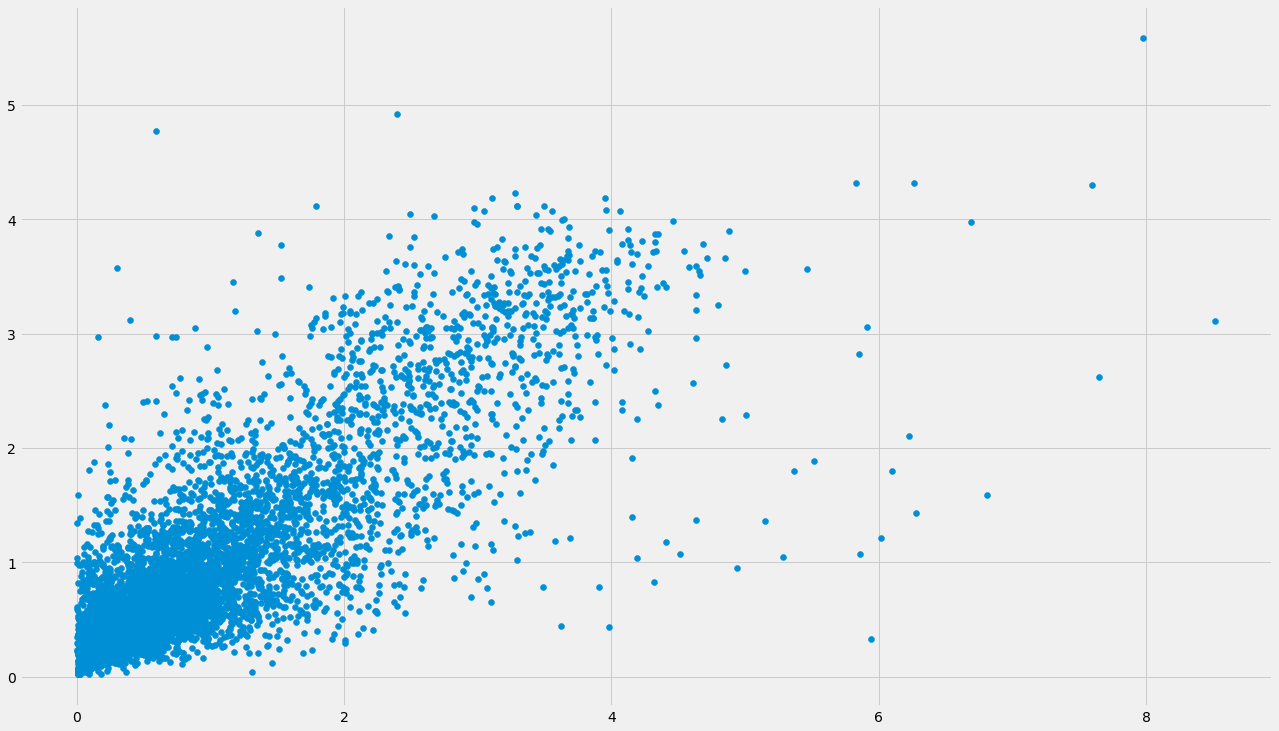

In [61]:
df_pred = pd.DataFrame(list(y_valid), columns = ['y_valid'])
df_pred['y_pred'] = list(y_pred)

plt.scatter(df_pred['y_valid'], df_pred['y_pred'])

In [62]:
df_pred.corr()

,y_valid,y_pred
y_valid,1.000000,0.818963
y_pred,0.818963,1.000000


## Investigate Optimization data

Text(0.5, 1.0, ' Error vs k Hyperparameter')

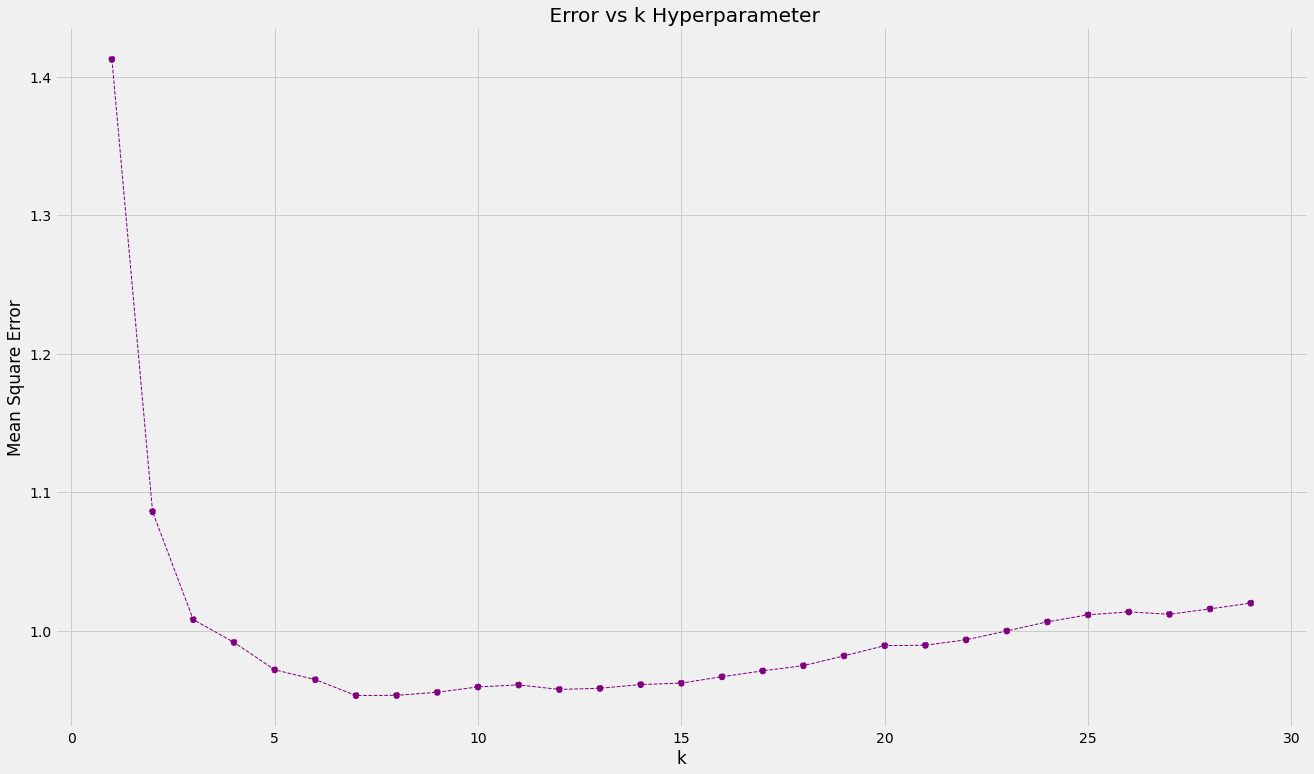

In [65]:
s = []
mse = []
for r in results:
        s.append(r['params'][0])
        mse.append(r['MSE'])

plt.plot((s), mse / np.mean(mse), c = 'purple', linewidth = 1, linestyle = '--')
plt.scatter((s), mse / np.mean(mse), c = 'purple', linewidth = 1, linestyle = '--')
plt.xlabel('k')
plt.ylabel('Mean Square Error')
plt.title(' Error vs k Hyperparameter')

Text(0.5, 1.0, ' Error vs k Hyperparameter')

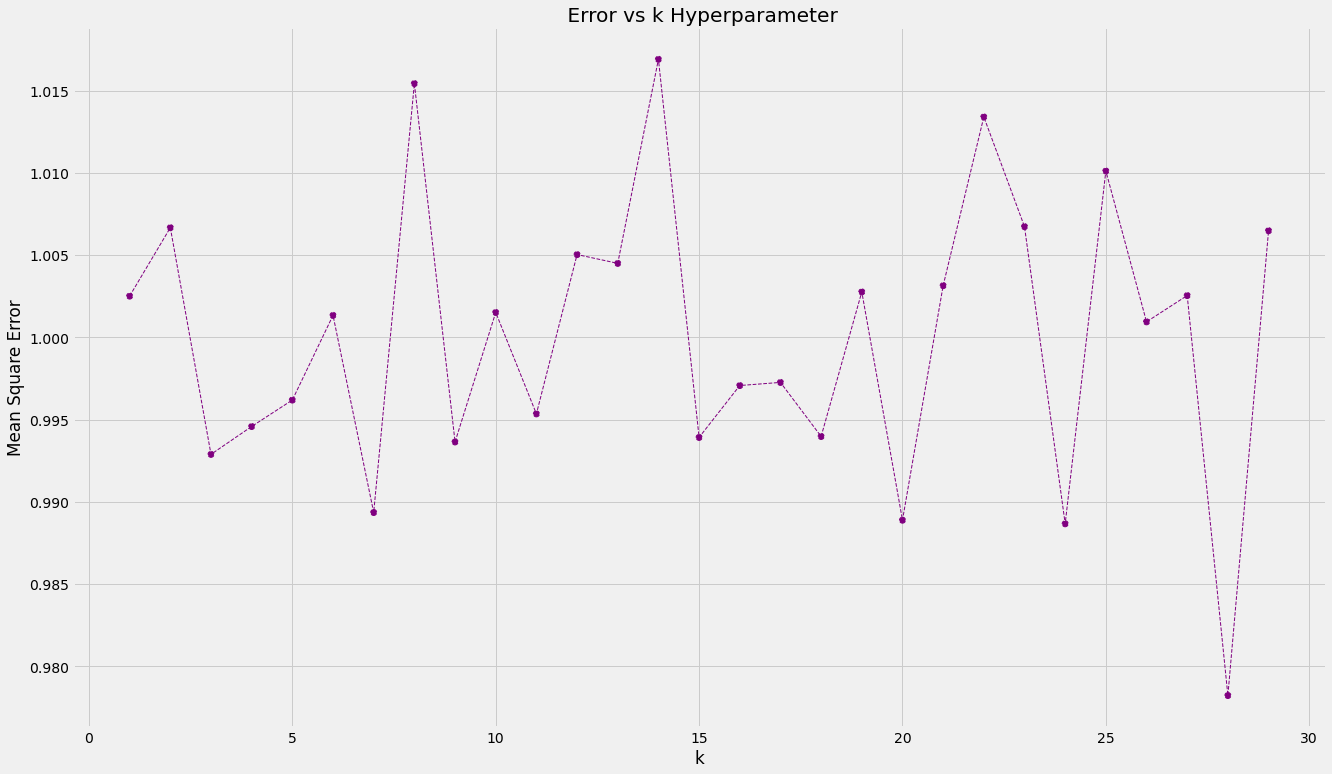

In [69]:
s = []
mse = []
for r in results:
        s.append(r['params'][0])
        mse.append(r['runtime'])

plt.plot((s), mse / np.mean(mse), c = 'purple', linewidth = 1, linestyle = '--')
plt.scatter((s), mse / np.mean(mse), c = 'purple', linewidth = 1, linestyle = '--')
plt.xlabel('k')
plt.ylabel('Mean Square Error')
plt.title(' Error vs k Hyperparameter')